## Trade off between Diversity and Sensitivity

### Sensitivity
In the worst case, by adding label noises to different tasks, how largely the final ranking would change?

In [1]:
from bencheval.data import load_cardinal_benchmark, cardinal_benchmark_list
from bencheval.measures.cardinal import get_sensitivity

sensitivity = {}  # the variance for all rankings based on only one task
for dataset_name in cardinal_benchmark_list:
    data, cols = load_cardinal_benchmark(dataset_name)
    sensitivity[dataset_name] = get_sensitivity(data, cols)
    print("%s %.2lf %.2lf" % (dataset_name, sensitivity[dataset_name][0], sensitivity[dataset_name][1]))


GLUE 0.11 0.72
SuperGLUE 0.12 0.33
MTEB 0.18 0.62
BigBenchHard 0.24 0.81
MMLU 0.34 1.00
OpenLLM 0.54 0.86
VTAB 0.05 0.27


### Diversity
How largely the rankings on each task differ from each other?

In [2]:
from bencheval.data import load_cardinal_benchmark, cardinal_benchmark_list
from bencheval.measures.cardinal import get_diversity

diversity = {}  # the variance for all rankings based on only one task
for dataset_name in cardinal_benchmark_list:
    data, cols = load_cardinal_benchmark(dataset_name)
    diversity[dataset_name] = get_diversity(data, cols)
    print("%s %.2lf %.2lf" % (dataset_name, diversity[dataset_name][0], diversity[dataset_name][1]))


GLUE 0.16 0.72
SuperGLUE 0.13 0.47
MTEB 0.08 0.27
BigBenchHard 0.32 0.73
MMLU 0.53 0.79
OpenLLM 0.82 0.93
VTAB 0.19 0.38


### Dummy Baselines

In [3]:
import numpy as np
from bencheval.data import load_cardinal_benchmark
from bencheval.measures.cardinal import get_diversity, get_sensitivity

num_seed = 5
for dataset_name in ["ImageNet", "Constant", "Random"]:
    for seed in range(num_seed):
        data, cols = load_cardinal_benchmark(dataset_name, seed=seed)
        if dataset_name not in sensitivity.keys():
            sensitivity[dataset_name] = np.array(get_sensitivity(data, cols))
        else:
            sensitivity[dataset_name] += np.array(get_sensitivity(data, cols))
    sensitivity[dataset_name] /= float(num_seed)

for dataset_name in ["ImageNet", "Constant", "Random"]:
    for seed in range(num_seed):
        data, cols = load_cardinal_benchmark(dataset_name, seed=seed)
        if dataset_name not in diversity.keys():
            diversity[dataset_name] = np.array(get_diversity(data, cols))
        else:
            diversity[dataset_name] += np.array(get_diversity(data, cols))
    diversity[dataset_name] /= float(num_seed)



### Save the data

In [4]:
import os
import joblib as jbl

dir_cache = os.path.join(os.getcwd(), ".cache")
os.makedirs(dir_cache, exist_ok=True)
path_sensitivity = os.path.join(dir_cache, "cardinal_sensitivity.jbl")
path_diversity = os.path.join(dir_cache, "cardinal_diversity.jbl")


In [5]:

jbl.dump(sensitivity, path_sensitivity)
jbl.dump(diversity, path_diversity)


['/Users/gzhang/Codes/Project-BenchmarkAggregation/.cache/cardinal_diversity.jbl']

In [6]:
sensitivity = jbl.load(path_sensitivity)
diversity = jbl.load(path_diversity)

### Draw the figures

Corr=0.95


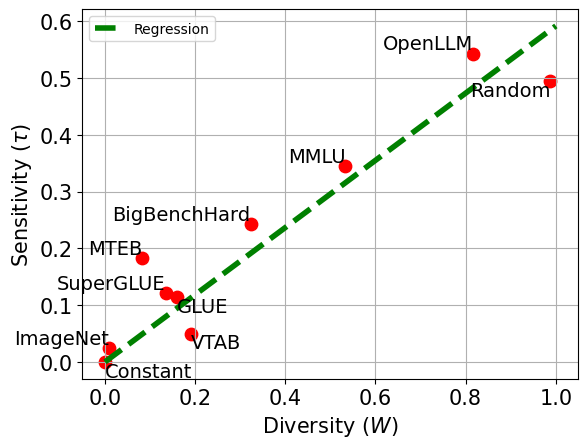

In [7]:
import numpy as np
from zarth_utils.drawer import Drawer
from bencheval.data import cardinal_benchmark_list

dataset_names = cardinal_benchmark_list + ["ImageNet", "Constant", "Random"]
x = [diversity[i][0] for i in dataset_names]
y = [sensitivity[i][0] for i in dataset_names]
print("Corr=%.2lf" % float(np.corrcoef(np.array(x), np.array(y))[0, 1]))

drawer = Drawer(unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, [y], index=1, xlabel=r"Diversity ($W$)", ylabel=r"Sensitivity ($\tau$)",
                          mode="scatter", use_marker=True, linewidth=80)
for i, label in enumerate(dataset_names):
    if label in ["GLUE", "Constant", "VTAB"]:
        ax.text(x[i], y[i], label, fontsize=14, ha='left', va='top')
    elif label in ["Random"]:
        ax.text(x[i], y[i], label, fontsize=14, ha='right', va='top')
    else:
        ax.text(x[i], y[i], label, fontsize=14, ha='right', va='bottom')
ax.grid()

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

x = np.array(x).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
clf = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("lin_reg", Ridge(fit_intercept=False, alpha=0.0))
])
clf.fit(x, y)

x2 = np.linspace(0.00, 1.00, 100).reshape(-1, 1)
y2 = clf.predict(x2.reshape(-1, 1)).reshape(-1, 1)
ax.plot(x2, y2, color="green", linewidth=4, linestyle="--", label="Regression")
ax.legend()
# 
drawer.save("cardinal_trade_off_tau.pdf")

Corr=0.75


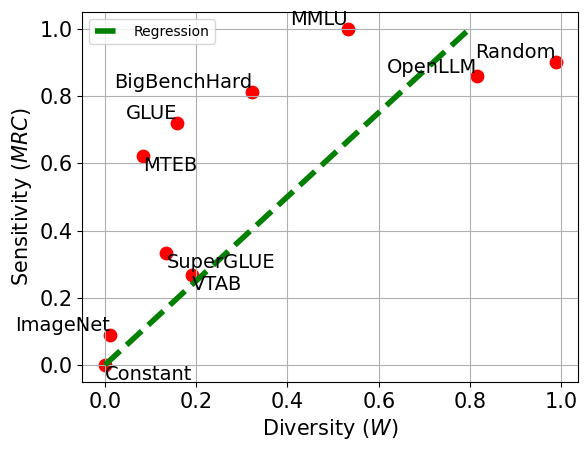

In [8]:
import numpy as np
from zarth_utils.drawer import Drawer
from bencheval.data import cardinal_benchmark_list

dataset_names = cardinal_benchmark_list + ["ImageNet", "Constant", "Random"]
x = [diversity[i][0] for i in dataset_names]
y = [sensitivity[i][1] for i in dataset_names]
print("Corr=%.2lf" % float(np.corrcoef(np.array(x), np.array(y))[0, 1]))

drawer = Drawer(unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, [y], index=1, xlabel=r"Diversity ($W$)", ylabel=r"Sensitivity ($MRC$)",
                          mode="scatter", use_marker=True, linewidth=80)
for i, label in enumerate(dataset_names):
    if label in ["SuperGLUE", "MTEB", "Constant", "VTAB"]:
        ax.text(x[i], y[i], label, fontsize=14, ha='left', va='top')
    else:
        ax.text(x[i], y[i], label, fontsize=14, ha='right', va='bottom')
ax.grid()

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

x = np.array(x).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
clf = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("lin_reg", Ridge(fit_intercept=False, alpha=0.0))
])
clf.fit(x, y)

x2 = np.linspace(0.00, 1.00, 100).reshape(-1, 1)
y2 = clf.predict(x2.reshape(-1, 1)).reshape(-1, 1)
idxs = [i for i in range(len(y2)) if y2[i] <= 1.0]
x2 = x2[idxs]
y2 = y2[idxs]
ax.plot(x2, y2, color="green", linewidth=4, linestyle="--", label="Regression")
ax.legend()

drawer.save("cardinal_trade_off_MRC.pdf")

## Sensitivity versus minimal noise portion $\epsilon$

In [1]:
from collections import defaultdict
from bencheval.data import cardinal_benchmark_list, load_cardinal_benchmark
from bencheval.measures.cardinal import get_sensitivity

sensitivity_vs_minvalue = defaultdict(dict)

minimal_value_list = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
dataset_name_list = cardinal_benchmark_list + ["ImageNet", "Constant", "Random"]

In [2]:

for minimal_value in minimal_value_list:
    for dataset_name in dataset_name_list:
        data, cols = load_cardinal_benchmark(dataset_name)
        sensitivity_vs_minvalue[minimal_value][dataset_name] = get_sensitivity(data, cols, min_value=minimal_value)
        print("%.2lf %s %.2lf %.2lf" % (
            minimal_value,
            dataset_name,
            sensitivity_vs_minvalue[minimal_value][dataset_name][0],
            sensitivity_vs_minvalue[minimal_value][dataset_name][1]
        ))



0.00 GLUE 0.13 0.72
0.00 SuperGLUE 0.14 0.48
0.00 OpenLLM 0.55 0.87
0.00 MMLU 0.47 1.00
0.00 BigBenchHard 0.34 0.81
0.00 MTEB 0.38 0.72
0.00 VTAB 0.07 0.27
0.00 ImageNet 0.03 0.12
0.00 Constant 0.00 0.00
0.00 Random 0.55 0.94
0.01 GLUE 0.11 0.72
0.01 SuperGLUE 0.12 0.33
0.01 OpenLLM 0.54 0.86
0.01 MMLU 0.34 1.00
0.01 BigBenchHard 0.24 0.81
0.01 MTEB 0.18 0.62
0.01 VTAB 0.05 0.27
0.01 ImageNet 0.02 0.09
0.01 Constant 0.00 0.00
0.01 Random 0.51 0.93
0.02 GLUE 0.10 0.72
0.02 SuperGLUE 0.12 0.33
0.02 OpenLLM 0.53 0.84
0.02 MMLU 0.25 0.99
0.02 BigBenchHard 0.18 0.77
0.02 MTEB 0.12 0.51
0.02 VTAB 0.05 0.27
0.02 ImageNet 0.02 0.07
0.02 Constant 0.00 0.00
0.02 Random 0.49 0.83
0.05 GLUE 0.07 0.66
0.05 SuperGLUE 0.10 0.30
0.05 OpenLLM 0.51 0.78
0.05 MMLU 0.11 0.60
0.05 BigBenchHard 0.10 0.66
0.05 MTEB 0.06 0.26
0.05 VTAB 0.03 0.13
0.05 ImageNet 0.01 0.06
0.05 Constant 0.00 0.00
0.05 Random 0.40 0.77
0.10 GLUE 0.05 0.62
0.10 SuperGLUE 0.07 0.19
0.10 OpenLLM 0.46 0.71
0.10 MMLU 0.06 0.26
0.10 Big

In [2]:
import os
import joblib as jbl

dir_cache = os.path.join(os.getcwd(), ".cache")
os.makedirs(dir_cache, exist_ok=True)

In [26]:
jbl.dump(sensitivity_vs_minvalue, os.path.join(dir_cache, "cardinal_sensitivity_vs_minvalue.jbl"))

['/Users/gzhang/Codes/Project-BenchmarkAggregation/.cache/cardinal_sensitivity_vs_minvalue.jbl']

In [3]:
sensitivity_vs_minvalue = jbl.load(os.path.join(dir_cache, "cardinal_sensitivity_vs_minvalue.jbl"))

In [4]:
!pip install seaborn

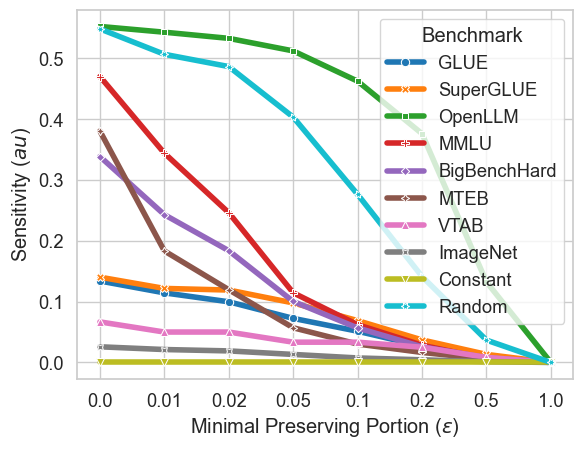

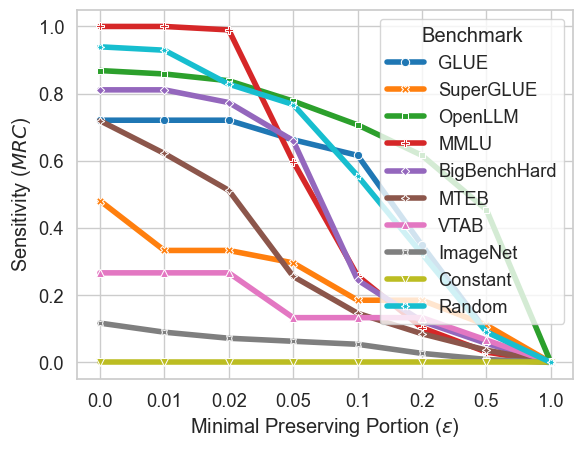

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

x = list(np.arange(len(minimal_value_list) + 1))
y = [[
         sensitivity_vs_minvalue[minimal_value][dataset_name][0]
         for minimal_value in minimal_value_list] + [0.0]
     for dataset_name in dataset_name_list
     ]
labels = dataset_name_list
data = pd.DataFrame({
    "Minimal Preserving Portion ($\epsilon$)": x * len(dataset_name_list),
    "Sensitivity ($\tau$)": np.array(y).flatten(),
    "Benchmark": np.array(labels).repeat(len(minimal_value_list) + 1)
})

plt.figure(figsize=(6.4, 4.8))
plt.tight_layout()
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")  #
sns.set_palette('tab10')
sns.lineplot(data, x="Minimal Preserving Portion ($\epsilon$)", y="Sensitivity ($\tau$)", hue="Benchmark",
             style="Benchmark",
             markers=True, dashes=False,
             linewidth=4
             )
plt.xticks(x, minimal_value_list + [1.0])
plt.savefig("figures/cardinal_tau_vs_minvalue.pdf", dpi=300, bbox_inches='tight')

y = [
    [
        sensitivity_vs_minvalue[minimal_value][dataset_name][1]
        for minimal_value in minimal_value_list
    ] + [0.0]
    for dataset_name in dataset_name_list
]
data = pd.DataFrame({
    "Minimal Preserving Portion ($\epsilon$)": x * len(dataset_name_list),
    "Sensitivity ($MRC$)": np.array(y).flatten(),
    "Benchmark": np.array(labels).repeat(len(minimal_value_list) + 1)
})
plt.figure(figsize=(6.4, 4.8))
plt.tight_layout()
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")  #
sns.set_palette('tab10')
sns.lineplot(data, x="Minimal Preserving Portion ($\epsilon$)", y="Sensitivity ($MRC$)", hue="Benchmark",
             style="Benchmark",
             markers=True, dashes=False,
             linewidth=4
             )
plt.xticks(x, minimal_value_list + [1.0])
plt.savefig('figures/cardinal_mrc_vs_minvalue.pdf', dpi=300, bbox_inches='tight')



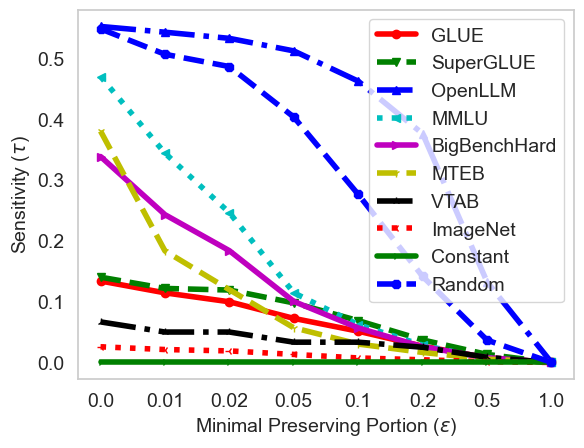

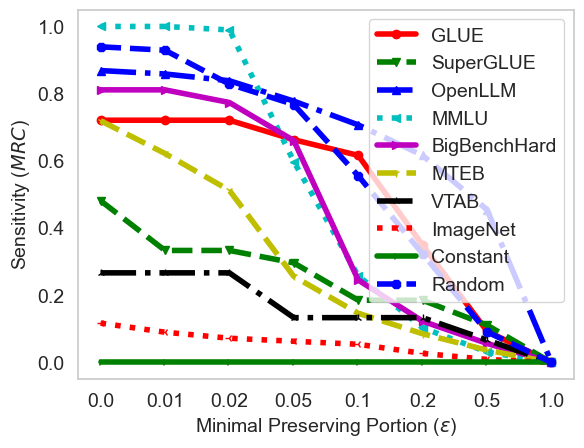

In [6]:
from zarth_utils.drawer import Drawer

drawer = Drawer(num_col=1, unit_row_length=6.4, unit_col_length=4.8)
x = list(np.arange(len(minimal_value_list) + 1))
y = [[
         sensitivity_vs_minvalue[minimal_value][dataset_name][0]
         for minimal_value in minimal_value_list] + [0.0]
     for dataset_name in dataset_name_list
     ]
labels = dataset_name_list
ax = drawer.draw_one_axes(x, y, index=1,
                          xlabel=r"Minimal Preserving Portion ($\epsilon$)", ylabel=r"Sensitivity ($\tau$)",
                          mode="plot", use_marker=True, labels=labels, fontsize=14, linewidth=4)
ax.set_xticks(x)
ax.set_xticklabels(minimal_value_list + [1.0])
ax.grid()
# drawer.save("cardinal_tau_vs_minvalue.pdf")

drawer = Drawer(num_col=1, unit_row_length=6.4, unit_col_length=4.8)
y = [[
         sensitivity_vs_minvalue[minimal_value][dataset_name][1]
         for minimal_value in minimal_value_list
     ] + [0.0]
     for dataset_name in dataset_name_list
     ]
labels = dataset_name_list
ax = drawer.draw_one_axes(x, y, index=1,
                          xlabel=r"Minimal Preserving Portion ($\epsilon$)", ylabel=r"Sensitivity ($MRC$)",
                          mode="plot", use_marker=True, labels=labels, fontsize=14, linewidth=4)
ax.set_xticks(x)
ax.set_xticklabels(minimal_value_list + [1.0])
ax.grid()
# drawer.save("cardinal_mrc_vs_minvalue.pdf")



## Subset Rank Change Experiment

In [16]:
from scipy.stats import rankdata
from bencheval.utils.metric import get_rank_diff
from bencheval.data import cardinal_benchmark_list, load_cardinal_benchmark

np.random.seed(0)

x = list(np.arange(1, 7))
y1_all, y2_all = [], []
dataset_name_list = cardinal_benchmark_list + ["ImageNet", "Constant", "Random"]
for dataset_name in dataset_name_list:
    data, cols = load_cardinal_benchmark(dataset_name)
    old_rank = rankdata(-data[cols].values.mean(1), method="average")
    y1, y2 = [], []
    for subset_size in x:
        min_y = (1, 1)
        for _ in range(1000):
            subset = list(np.random.choice(cols, subset_size, replace=False))
            new_rank = rankdata(-data[subset].values.mean(1), method="average")
            res = get_rank_diff(new_rank, old_rank)
            if res < min_y:
                min_y = res
        y1.append(min_y[0])
        y2.append(min_y[1])
    y1_all.append(y1)
    y2_all.append(y2)

In [17]:
import joblib as jbl

dir_cache = os.path.join(os.getcwd(), ".cache")
os.makedirs(dir_cache, exist_ok=True)

In [18]:
jbl.dump((x, y1_all, y2_all, dataset_name_list), os.path.join(dir_cache, "cardinal_subset_min_tau.jbl"))

['/Users/gzhang/Codes/Project-BenchmarkAggregation/.cache/cardinal_subset_min_tau.jbl']

In [19]:
x, y1_all, y2_all, dataset_name_list = jbl.load(os.path.join(dir_cache, "cardinal_subset_min_tau.jbl"))

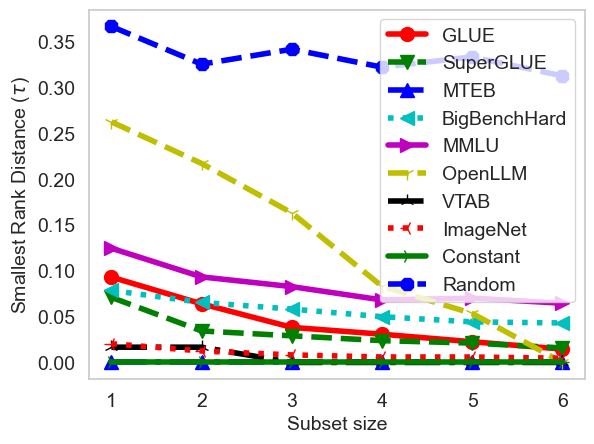

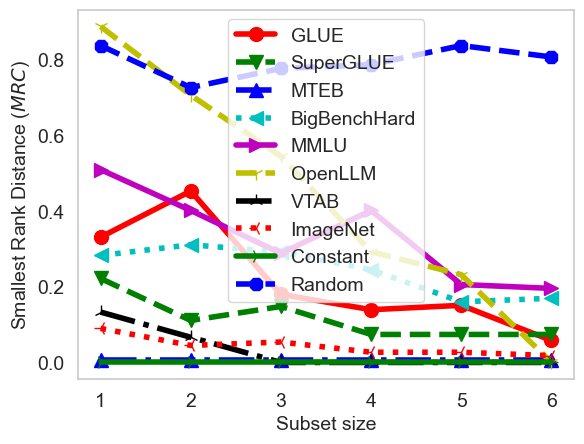

In [20]:
from zarth_utils.drawer import Drawer

drawer = Drawer(num_col=1, num_row=1, unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, y1_all, index=1, xlabel="Subset size", ylabel=r"Smallest Rank Distance ($\tau$)",
                          labels=dataset_name_list, mode="plot",
                          linewidth=4, fontsize=14, use_marker=True, markersize=10)
ax.grid()
drawer.figure.savefig(os.path.join("figures", "cardinal_subset_min_tau.pdf"), bbox_inches='tight')

drawer = Drawer(num_col=1, num_row=1, unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, y2_all, index=1, xlabel="Subset size", ylabel=r"Smallest Rank Distance ($MRC$)",
                          labels=dataset_name_list, mode="plot",
                          linewidth=4, fontsize=14, use_marker=True, markersize=10)
ax.grid()
drawer.figure.savefig(os.path.join("figures", "cardinal_subset_min_mrc.pdf"), bbox_inches='tight')